In [1]:
from djchurchland import *
from djchurchland.schema import * # Imports all schemas from the database
from djchurchland.utils import *
from djchurchland.chipmunk.psychometric import PsychometricFit
from djchurchland.chipmunk.fit_psychometric import cumulative_gaussian, PsychometricRegression
from chiCa.chiCa import separate_axes

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

%matplotlib widget
%load_ext autoreload
%autoreload 2

[2025-08-12 16:08:59,547][INFO]: Connecting gabriel@localhost:3306
[2025-08-12 16:08:59,554][INFO]: Connected gabriel@localhost:3306


#### Identify sessions with good behavior (>80% performance)

In [2]:
mice = np.unique(PsychometricFit.fetch("subject_name"))
performance_threshold = 0.7
good_behavior_sessions = dict()
for mouse in mice:
    if mouse in ["GRB001", "GRB002", "GRB003", "GRB004", "GRB007"]: #mice only trained on 1s wait time version of the task
        continue

    trials_df = pd.DataFrame(Task.TrialSet() & f'subject_name = "{mouse}"')

    easy_perf_df = pd.DataFrame({
        'session_datetime': trials_df.session_datetime,
        'avg_performance': trials_df.performance.apply(lambda x: np.mean([x[0], x[-1]]))})

    #find sessions with performance above threshold in database
    try:
        sessions = (PsychometricFit & f'subject_name = "{mouse}"' & 
                                'session_datetime in (' + 
                                ','.join([f'"{dt}"' for dt in easy_perf_df[easy_perf_df.avg_performance >= performance_threshold].session_datetime.dt.strftime('%Y-%m-%d %H:%M:%S')]) +
                                ')').fetch('session_datetime')
    except:
        print(f"Mouse {mouse} has no sessions with performance above {performance_threshold}")
        continue
    
    if len(sessions) >= 10:
        good_behavior_sessions.update({mouse:sessions})

In [3]:
good_behavior_sessions.keys()

dict_keys(['GRB005', 'GRB006', 'GRB026', 'GRB027', 'GRB036', 'GRB037', 'GRB038', 'GRB039', 'GRB041', 'GRB045', 'GRB046', 'GRB047'])

#### Identify good behavior ephys sessions

In [4]:
GRB006_ephys_sessions = [
    '20240424_150511', '20240429_174359', '20240430_183206', '20240501_195113',
    '20240502_161058', '20240506_171411', '20240507_180829', '20240508_173227',
    '20240509_163637', '20240510_180411', '20240530_164626', '20240604_123410',
    '20240605_133531', '20240606_141045', '20240607_133855', '20240612_142350',
    '20240613_140011', '20240614_132538', '20240620_124808', '20240621_143838',
    '20240628_130506', '20240702_134736', '20240715_134530', '20240716_151257',
    '20240717_154846', '20240723_142451', '20240724_144439', '20240806_141817',
    '20240814_154434'
]

ephys_mice = ["GRB006"]
behavior_ephys_sessions = {}

for mice in ephys_mice:
    ephys_sessions = []
    for date in GRB006_ephys_sessions:
        ephys_sessions.append(datetime.strptime(date, '%Y%m%d_%H%M%S'))
    
    ephys_set = set(ephys_sessions)
    behavior_set = set(good_behavior_sessions[mice])
    behavior_ephys_sessions[mice] = ephys_set.intersection(behavior_set)  #get the ephys sessions that are also good behavior sessions

#### Single animal psychometric fit plotting

In [5]:
def plot_single_mouse_psychometric_fit(
    mouse_id,
    query=None,
    ax=None,
    plot_mode='both',
    sessions_list=None
):
    """
    Plot individual sessions and average psychometric fit for a single mouse.

    Args:
        mouse_id: The ID of the mouse to plot.
        query: Optional additional query as a string.
        ax: Optional matplotlib axis to plot on.
        plot_mode: Mode of plotting ('individual', 'average', 'both').
        sessions_list: List of session_datetime strings or datetime objects to include.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import datetime

    if ax is None:
        _ , ax = plt.subplots(figsize=(5, 5))

    # Build the base query with the mouse_id
    combined_query = f'subject_name="{mouse_id}"'

    # Add any additional query
    if query:
        combined_query += f' AND ({query})'

    # Prepare session query if sessions_list is provided
    if sessions_list is not None:
        # Ensure all session_datetimes are strings formatted correctly
        sessions_list_str = [
            f'"{s.strftime("%Y-%m-%d %H:%M:%S")}"' if isinstance(s, datetime.datetime) else f'"{s}"' 
            for s in sessions_list
        ]
        session_query = 'session_datetime in (' + ', '.join(sessions_list_str) + ')'
        combined_query += f' AND ({session_query})'

    # Assign a color to the mouse
    color = 'black'

    # Fetch fits for the current mouse with querys
    fits = (PsychometricFit & combined_query).fetch(as_dict=True)
    if fits:
        if plot_mode in ['individual', 'both']:
            # Plot individual fits
            for fit in fits:
                nx = np.linspace(np.min(fit['stims']), np.max(fit['stims']), 100)
                ax.plot(
                    nx, cumulative_gaussian(*fit['fit_params'], nx),
                    linewidth=1, alpha=0.1, color=color
                )
                ax.plot(
                    fit['stims'], fit['p_side'], 'o',
                    markersize=4, alpha=0.1, color=color
                )

        if plot_mode in ['average', 'both']:
            print(f"Calculating average fit for {len(fits)} sessions for mouse {mouse_id}...")

            # Get trial data for all sessions of the current mouse
            trial_data = (
                (Chipmunk.Trial() & combined_query & 'response != 0')
                * Chipmunk.TrialParameters()
            )
            response_values, stim_values = trial_data.fetch('response', 'stim_rate')

            if len(response_values) > 0:
                # Convert responses: 1 (left) -> 0, -1 (right) -> 1
                all_responses = (response_values == -1).astype(int)
                all_stims = stim_values

                print(f"Combined data: {len(all_stims)} trials for mouse {mouse_id}")

                # Fit psychometric function to combined data
                ft = PsychometricRegression(
                    all_responses.astype(float),
                    exog=all_stims.astype(float)[:, np.newaxis]
                )
                res = ft.fit(min_required_stim_values=6)

                if res is not None:
                    print(f"Successfully fit average curve for mouse {mouse_id}")

                    # Plot average curve
                    nx = np.linspace(np.min(ft.stims), np.max(ft.stims), 100)
                    ax.plot(
                        nx, cumulative_gaussian(*res.params, nx),
                        linewidth=2, label=f'{mouse_id} Average', color=color
                    )

                    # Plot confidence intervals as vertical lines
                    for stim, p_side, ci in zip(ft.stims, ft.p_side, ft.ci_side):
                        ax.plot([stim, stim], ci, '-_', color=color)

                    # Plot average data points
                    ax.plot(
                        ft.stims, ft.p_side, 'o',
                        markerfacecolor='lightgray', markersize=6, color=color
                    )
                else:
                    print(f"Failed to fit average curve for mouse {mouse_id}")
            else:
                print(f"No trial data available for mouse {mouse_id} with the given querys.")
    else:
        print(f"No data available for mouse {mouse_id} with the given querys.")

    # Format plot
    ax.set_ylabel('P(right choice)', fontsize=14)
    ax.set_xlabel('Stimulus rate (Hz)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylim([0, 1])

    return ax

Calculating average fit for 29 sessions for mouse GRB006...
Combined data: 10394 trials for mouse GRB006
Successfully fit average curve for mouse GRB006


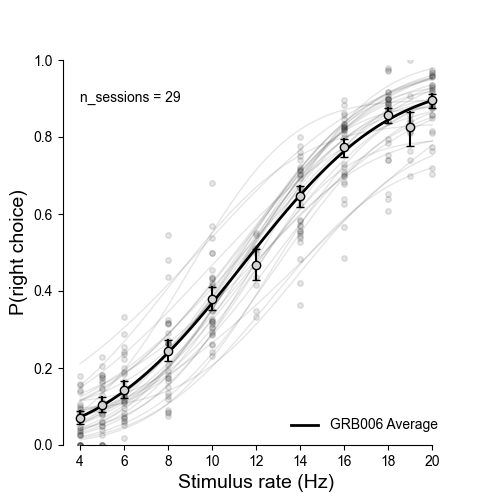

In [6]:
save_dir = '/Users/gabriel/Desktop/BSN_figures/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

mouse = "GRB006"
fig, ax = plt.subplots(figsize=(5, 5))

plot_single_mouse_psychometric_fit(
    mouse_id=mouse,
    ax=ax,
    plot_mode='both',
    sessions_list=behavior_ephys_sessions[mouse]
)

# plt.title(f'Psychometric Fits for {mouse}')
ax.legend(frameon=False, fontsize=10)
ax.text(4, 0.89, f'n_sessions = {len(behavior_ephys_sessions[mouse])}', fontsize=10)
separate_axes(ax)
# plt.savefig(pjoin(save_dir, f'{mouse}_ephys_psychometric_fits.svg'), format='svg', dpi=300)

#### Multi-animal psychometric fit plotting

In [7]:
def plot_multi_mouse_psychometric_fit(
    mouse_sessions_dict,
    query=None,
    ax=None
):
    """
    Plot average psychometric fits for multiple mice, each with their own session querys.

    Args:
        mouse_sessions_dict: Dictionary where keys are mouse IDs and values are lists of session_datetime
                             strings or datetime objects to include for that mouse.
        query: Optional additional query as a string.
        ax: Optional matplotlib axis to plot on.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import datetime

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    mice_list = list(mouse_sessions_dict.keys())

    # Assign colors to mice
    cmap = plt.get_cmap('viridis_r')
    colors = cmap(np.linspace(0,1,len(mice)))

    for mouse_id, color in zip(mice_list, colors):
        # Get sessions for this mouse
        sessions_list = mouse_sessions_dict[mouse_id]
        
        # Build the base query for each mouse
        combined_query = f'subject_name="{mouse_id}"'

        # Add any additional query
        if query:
            combined_query += f' AND ({query})'

        # Prepare session query if sessions_list is provided
        if sessions_list is not None:
            # Ensure all session_datetimes are strings formatted correctly
            sessions_list_str = [
                f'"{s.strftime("%Y-%m-%d %H:%M:%S")}"' if isinstance(s, datetime.datetime) else f'"{s}"' 
                for s in sessions_list
            ]
            session_query = 'session_datetime in (' + ', '.join(sessions_list_str) + ')'
            combined_query += f' AND ({session_query})'

        # Fetch fits for the current mouse with querys
        fits = (PsychometricFit & combined_query).fetch(as_dict=True)
        if fits:
            print(f"Calculating average fit for mouse {mouse_id} with {len(fits)} sessions...")
            
            # Get trial data for all sessions of the current mouse
            trial_data = (
                (Chipmunk.Trial() & combined_query & 'response != 0')
                * Chipmunk.TrialParameters()
            )
            response_values, stim_values = trial_data.fetch('response', 'stim_rate')

            if len(response_values) > 0:
                # Convert responses: 1 (left) -> 0, -1 (right) -> 1
                all_responses = (response_values == -1).astype(int)
                all_stims = stim_values

                print(f"Combined data: {len(all_stims)} trials for mouse {mouse_id}")

                # Fit psychometric function to combined data
                ft = PsychometricRegression(
                    all_responses.astype(float),
                    exog=all_stims.astype(float)[:, np.newaxis]
                )
                res = ft.fit(min_required_stim_values=6)

                if res is not None:
                    print(f"Successfully fit average curve for mouse {mouse_id}")

                    # Plot average curve
                    nx = np.linspace(np.min(ft.stims), np.max(ft.stims), 100)
                    ax.plot(
                        nx, cumulative_gaussian(*res.params, nx),
                        linewidth=2, label=f'{mouse_id}', color=color
                    )

                    # # Plot confidence intervals as vertical lines
                    # for stim, p_side, ci in zip(ft.stims, ft.p_side, ft.ci_side):
                    #     ax.plot([stim, stim], ci, '-_', color=color)

                    # Plot average data points
                    # ax.plot(
                    #     ft.stims, ft.p_side, 'o',
                    #     markerfacecolor='lightgray', markersize=6, color=color
                    # )
                else:
                    print(f"Failed to fit average curve for mouse {mouse_id}")
            else:
                print(f"No trial data available for mouse {mouse_id} with the given querys.")
        else:
            print(f"No data available for mouse {mouse_id} with the given querys.")

    # Format plot
    ax.set_ylabel('P(right choice)', fontsize=14)
    ax.set_xlabel('Stimulus rate (Hz)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylim([0, 1])

    return ax

Calculating average fit for mouse GRB005 with 40 sessions...
Combined data: 7246 trials for mouse GRB005
Successfully fit average curve for mouse GRB005
Calculating average fit for mouse GRB006 with 105 sessions...
Combined data: 32381 trials for mouse GRB006
Successfully fit average curve for mouse GRB006
Calculating average fit for mouse GRB026 with 31 sessions...
Combined data: 7985 trials for mouse GRB026
Successfully fit average curve for mouse GRB026
Calculating average fit for mouse GRB027 with 28 sessions...
Combined data: 10611 trials for mouse GRB027
Successfully fit average curve for mouse GRB027
Calculating average fit for mouse GRB036 with 58 sessions...
Combined data: 11443 trials for mouse GRB036
Successfully fit average curve for mouse GRB036
Calculating average fit for mouse GRB037 with 64 sessions...
Combined data: 16390 trials for mouse GRB037
Successfully fit average curve for mouse GRB037


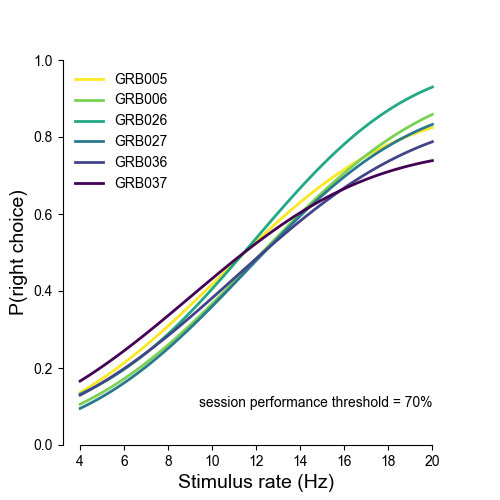

In [8]:
from os.path import join as pjoin

fig, ax = plt.subplots(figsize=(5, 5))
mice_list = list(good_behavior_sessions.keys())
save_dir = '/Users/gabriel/Desktop/BSN_figures/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

plot_multi_mouse_psychometric_fit(
    mouse_sessions_dict=good_behavior_sessions,
    ax=ax
)

ax.legend(frameon=False, fontsize=10, loc = 'upper left')
ax.text(20, 0.1, s=f'session performance threshold = {int(performance_threshold*100)}%', fontsize = 10, ha='right')
separate_axes(ax)
# plt.savefig(pjoin(save_dir, 'psychometric_fits_all_mice.svg'), format='svg', dpi=300, bbox_inches='tight')